# Project 2

## Experiment Setup

CPU: AMD Ryzen 5 7600X | 4691.105Mhz

Cache hierarchy:

L1d: 32 KB per core × 6

L1i: 32 KB per core × 6

L2: 1 MB per core × 6

L3: 32 MB shared

OS: Ubuntu 24.04.3 LTS

gcc: gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0

## Results

### 1. Zero-queue baselines:

Since MLC cant work well on my current AMD CPU, I create a ring-based benchmark for detecting. This benchmark is to measure memory access latency across different cache levels and main memory. It constructs a randomized pointer-chasing ring structure, where each memory access depends on the result of the previous one. By varying the working set size and stride, the benchmark reveals turning points that correspond to L1, L2, L3, and DRAM boundaries. The output reports the average latency per access in nanoseconds.

run:

In [ ]:
gcc -O3 -march=native -o bench benchmark.c

bash benchmark.sh

python3 plot_latency.py bench_result.txt

python table_cache_latency.py

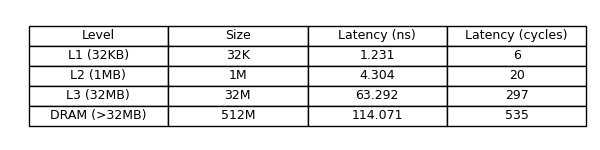

At 32KB corresponding to the L1 cache, the latency is very low at around 1.23 nanoseconds, which translates to only about 6 cycles, showing the extremely fast access of the closest cache. Moving to 1MB, which reflects the L2 cache, latency increases to about 4.3 nanoseconds or 20 cycles, still relatively fast but noticeably higher than L1. At 32MB, representing the shared L3 cache, latency rises sharply to about 63 nanoseconds or 297 cycles, indicating the overhead of accessing a much larger but slower cache. Finally, when the working set spills into main memory (here measured at 512MB), the latency jumps to about 114 nanoseconds, or over 500 cycles, highlighting the substantial performance gap between caches and DRAM.

### 2. Pattern & granularity sweep

run:

In [ ]:
gcc -O3 -march=native -o stride_sweep stride_sweep.c

bash stride.sh

python3 plot_stride.py stride.csv

| 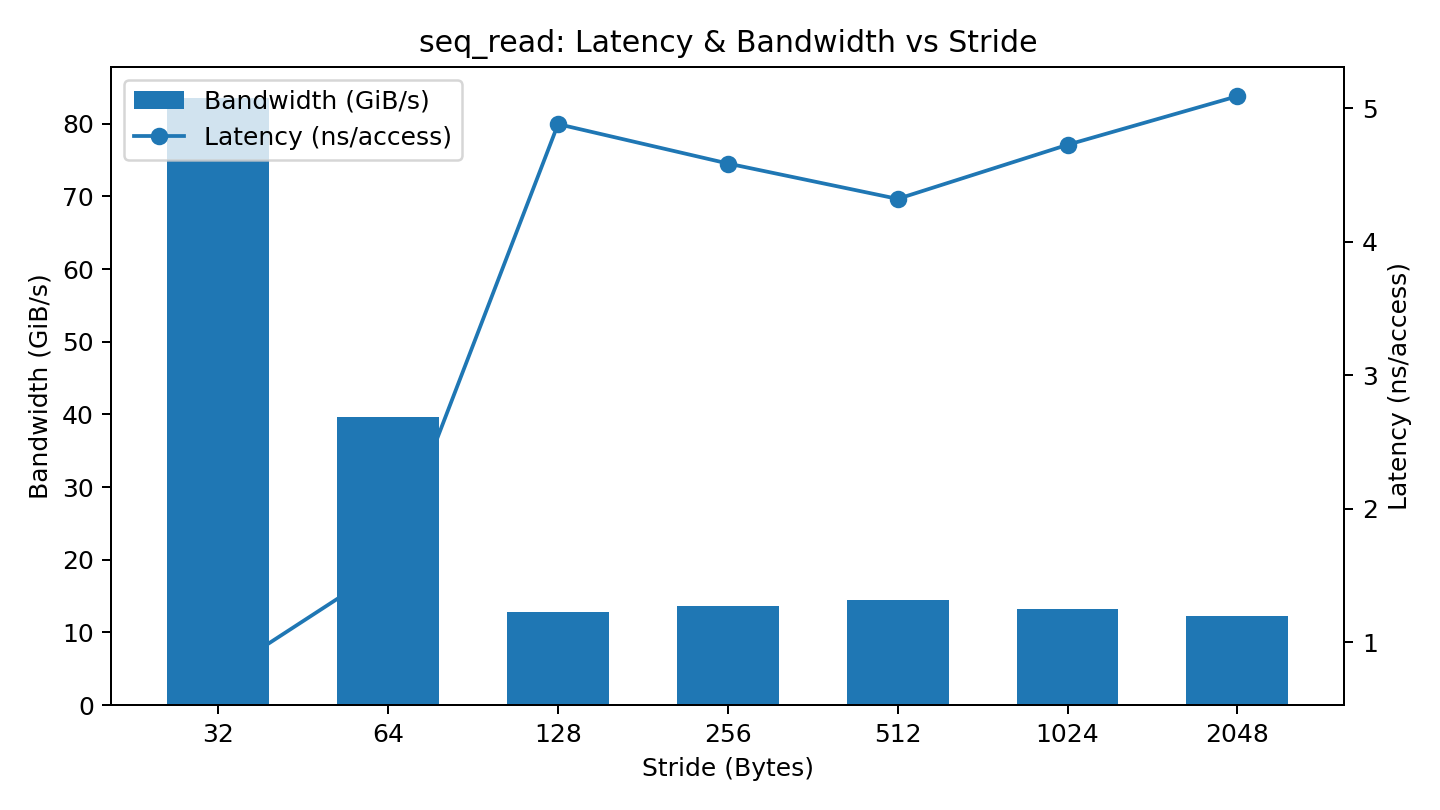 | 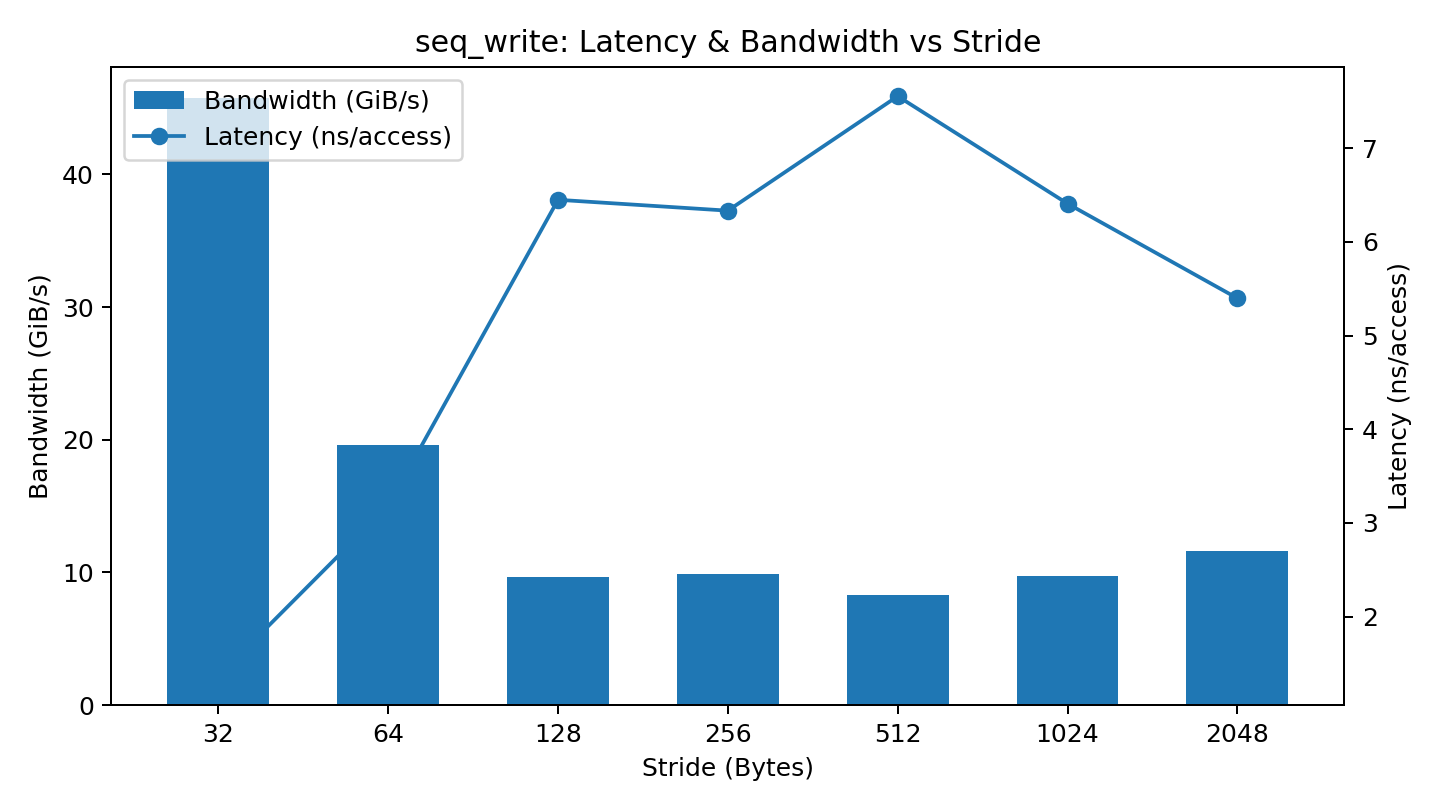 |
|----------------------------------------|------------------------------------------|


For sequential R/W, when the stride is small (32B/64B), the system achieves high bandwidth and low latency due to effective cache line utilization and hardware prefetching. As the stride increases, bandwidth drops sharply and latency rises, reflecting the loss of spatial locality and reduced prefetch efficiency.

| 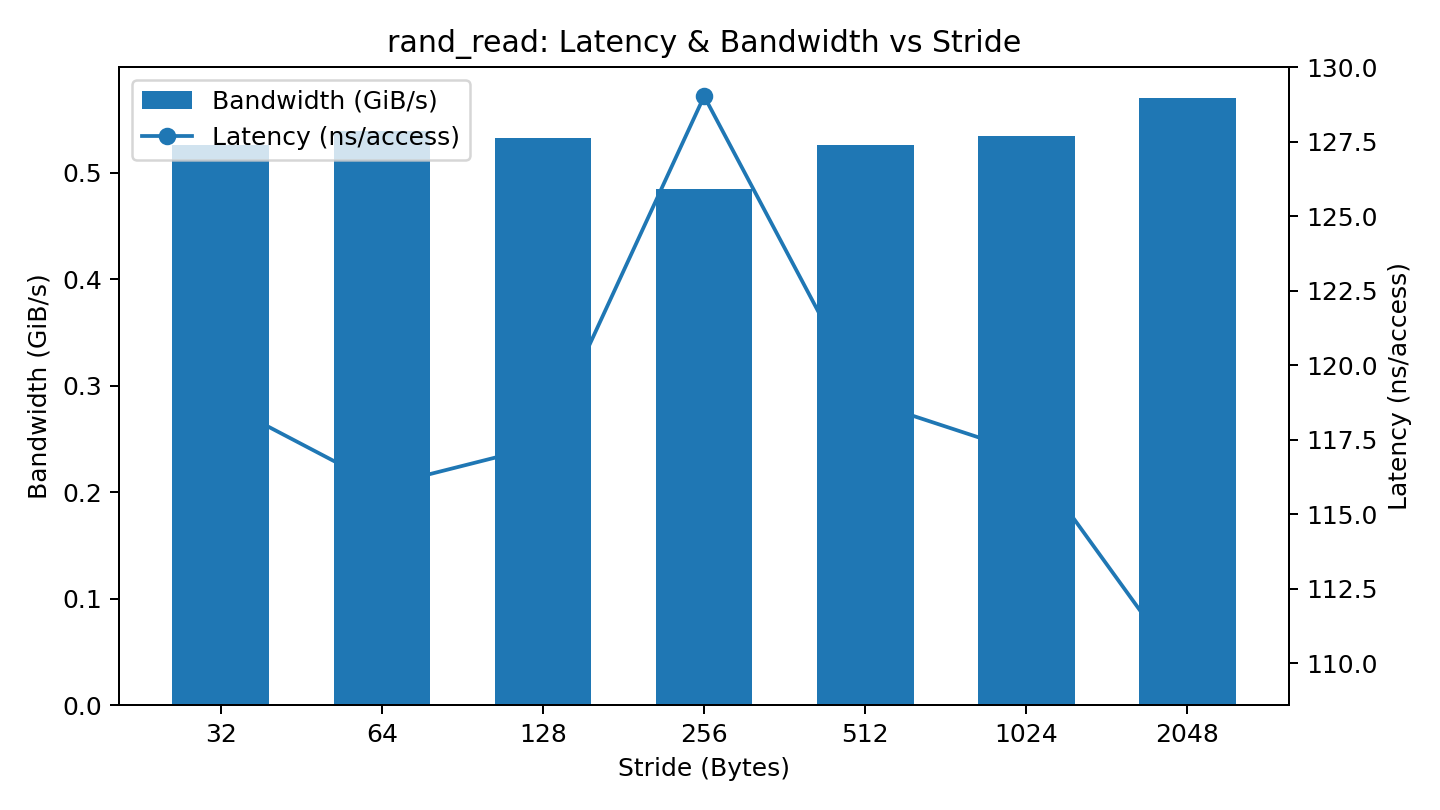 | 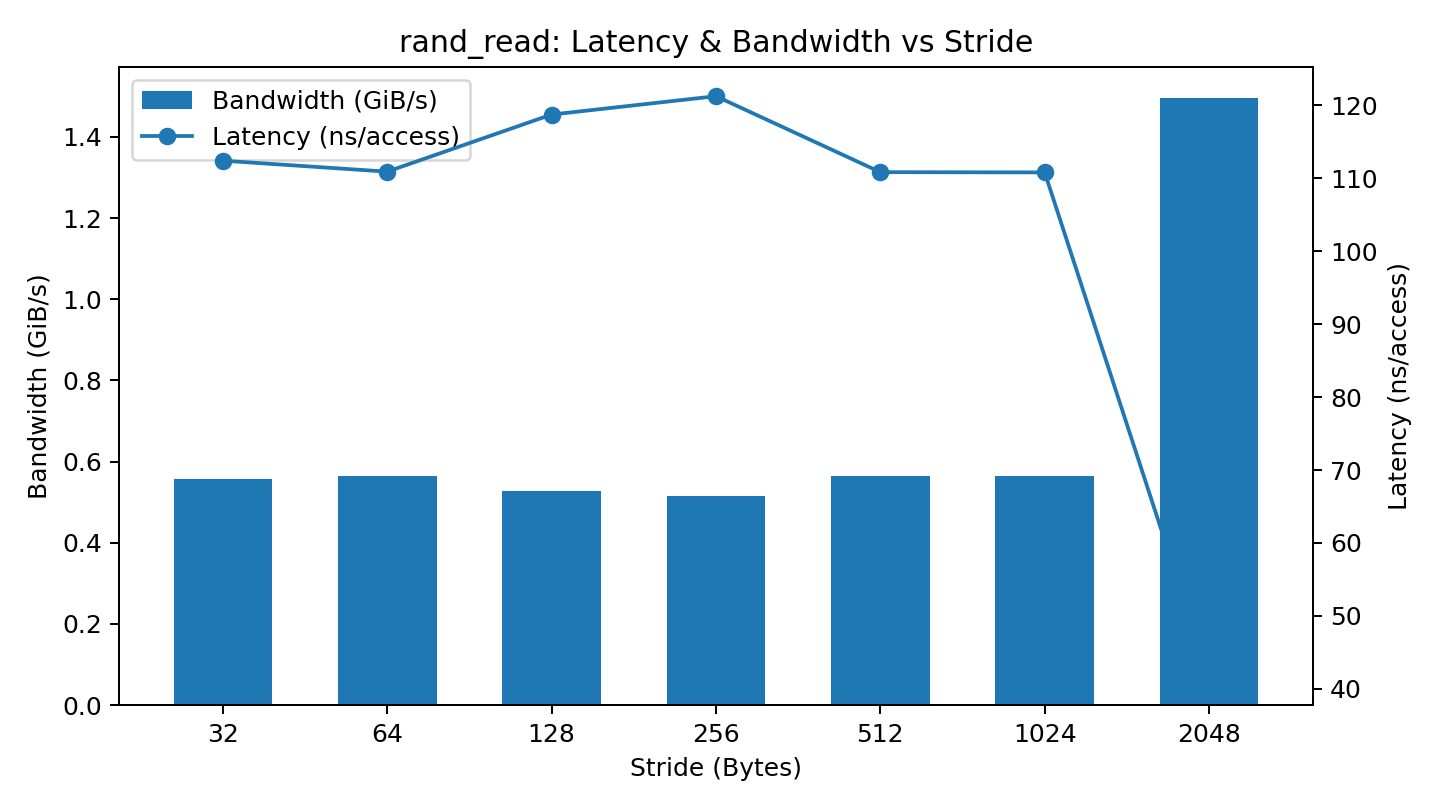 |
|----------------------------------------|------------------------------------------|

For random R/W, the overall performance shows much higher latency and significantly lower bandwidth compared to sequential access, since hardware prefetchers are largely ineffective in handling irregular access patterns. Without predictable access patterns, neither cache line utilization nor prefetching can be leveraged, leading to poor memory efficiency.

### 3. Read/Write mix sweep

run:

In [ ]:
gcc -O3 -march=native -o rw_mix rw_mix.c

bash rw_mix.bash

python3 plot_rw_mix.py rw_mix.csv

| 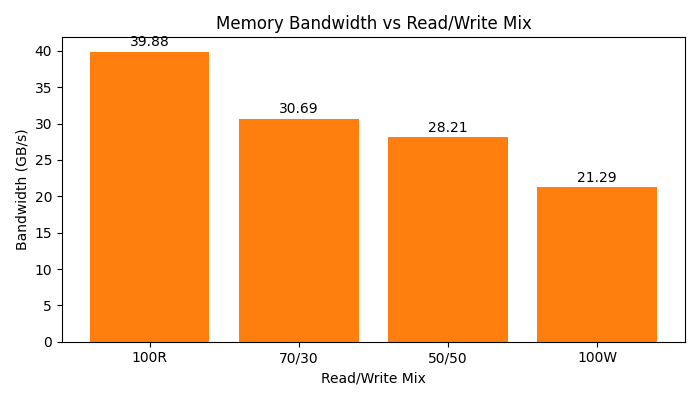 | 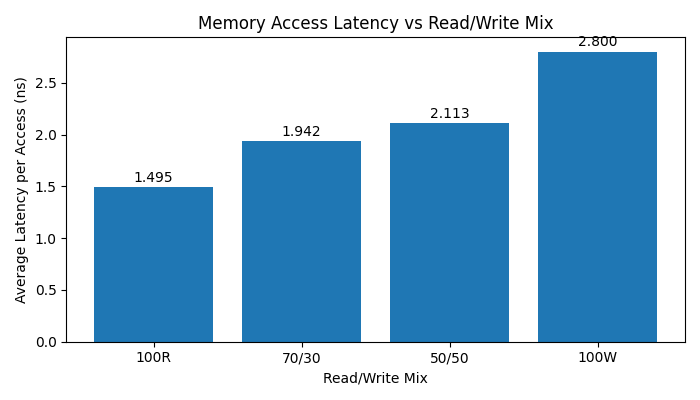 |
|----------------------------------------|------------------------------------------|

Reads are handled much more efficiently at the hardware level, while higher write ratios have increasingly negative effects on both latency and bandwidth.

### 4. Intensity sweep

run:

In [ ]:
gcc -O3 -pthread -march=native -o intensity intensity.c

bash intensity.sh

python3 plot_intensity.py intensity.csv


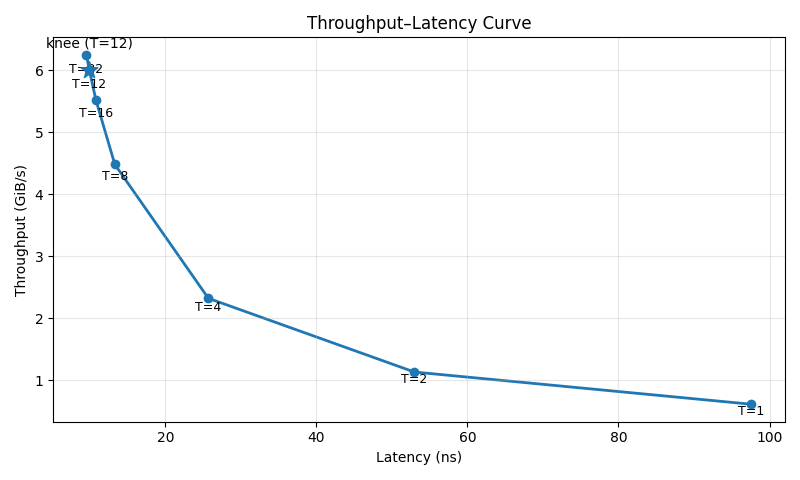

As the number of threads increases, latency gradually decreases while bandwidth first rises sharply and then enters a plateau. When the thread count reaches 12, the bandwidth is already close to 6.0 GB/s, and further increasing to 16 or 32 threads brings only marginal gains (around 5.5–6.2 GB/s). This indicates that the system has reached the “knee” region. 

The maximum throughput observed in the test is 6.25 GB/s (at T=32), while at the knee point (T=12), the throughput is 6.00 GB/s—about 96% of the peak. Before 12 threads, adding more threads significantly improves throughput, but beyond this point, the bandwidth barely increases and even fluctuates, while latency no longer improves.

From the perspective of theoretical bandwidth, DDR5-4800 dual-channel memory provides about 76.8 GB/s, whereas the measured maximum is 6.25 GiB/s (≈ 6.71 GB/s), which is only about 8.7% of the theoretical peak. According to Little’s Law, at low concurrency levels, increasing the number of threads boosts overall system throughput (λ) while reducing latency (W). However, once the knee point is reached, the number of queued requests (L) grows rapidly, leading to latency inflation. At this stage, performance improvements are no longer linear, exemplifying the law of diminishing returns.

### 5. Working-set size sweep

run:

In [ ]:
bash benchmark.sh

python3 plot_latency.py bench_result.txt

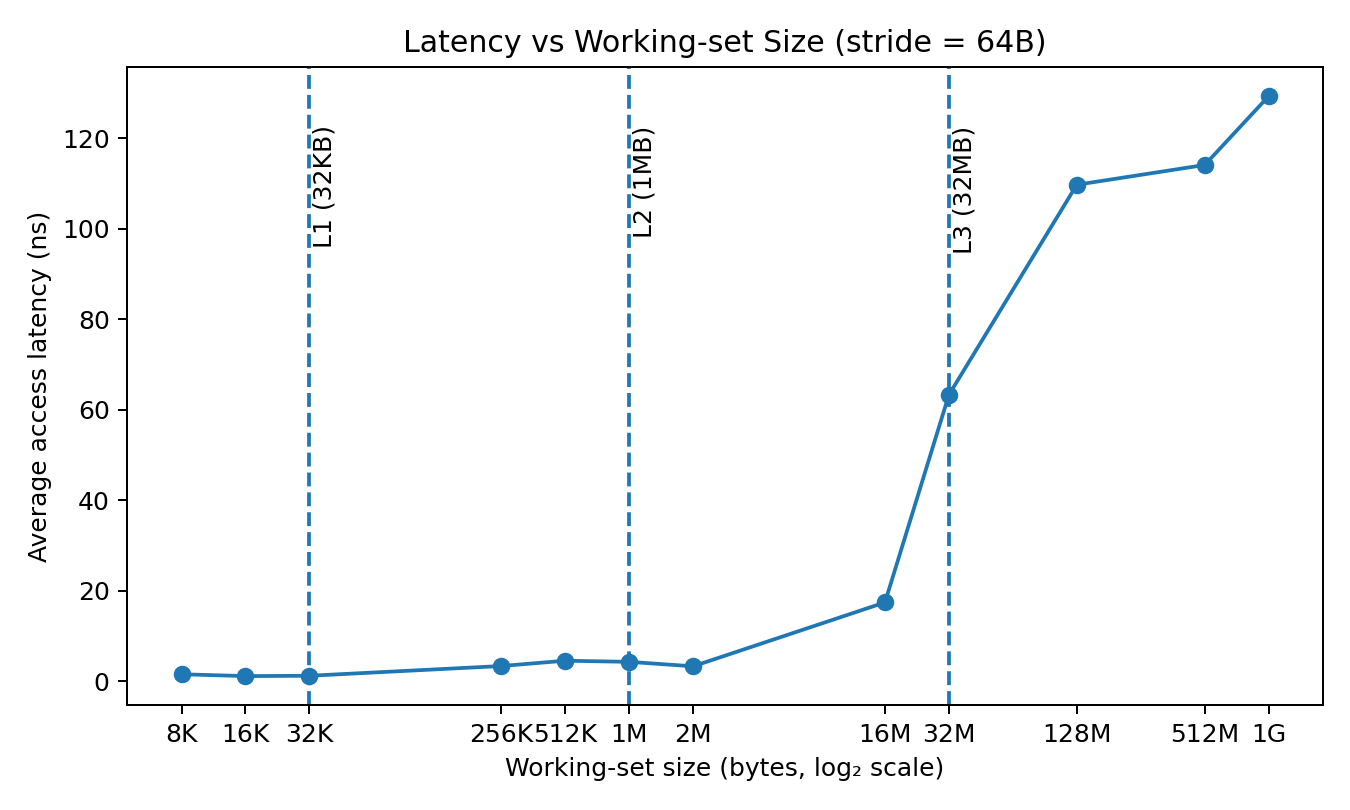

When the working set is very small, within about 32KB, the data can be entirely stored in the L1 cache, so the latency remains extremely low and stable. As the working set size grows beyond the L1 capacity, the curve exhibits a first noticeable jump, indicating that accesses are now spilling into the L2 cache. A second, larger increase in latency occurs around 1MB, which corresponds to the transition from L2 to L3 cache. Finally, when the working set exceeds approximately 32MB, the latency rises sharply again, showing that the cache hierarchy is no longer sufficient to contain the data, and most accesses must be served from DRAM.

### 6. Cache-miss impact (25 pts)

run: